Model training!

In [1]:
import pandas as pd
import numpy as np
from fastai.tabular.all import *
from sklearn.model_selection import StratifiedShuffleSplit

def modify_data():
    df = pd.read_csv('train.csv')
    df['Survived'] = df['Survived'].astype('category')
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    df['Fare_log'] = np.log1p(df['Fare'])
    df['cabin_height'] = df['Cabin'].str[0].fillna('U')
    df['Embarked'] = df['Embarked'].fillna(0)
    procs = [Categorify, FillMissing, Normalize]
    cat_names  = ['Sex','Embarked','cabin_height']
    cont_names = ['Fare_log','Age','SibSp','Parch']
    
    return build_base(df, procs, cat_names, cont_names)

def build_base(df,procs,cat_names,cont_names):

    tp = TabularPandas(
        df, 
        procs=procs,
        cat_names=cat_names, 
        cont_names=cont_names,
        y_names='Survived',
        y_block=RegressionBlock(),
        splits = RandomSplitter(0.2)(range_of(df)),
        )
    dls  = tp.dataloaders(path='.')
    learn = tabular_learner(
        dls,
        layers=[200,100],
        loss_func=MSELossFlat(),
        wd=0.1,
        metrics=[rmse, mae, R2Score()]
    )

    return learn, dls

def get_valid_data(learn, dls):
    valid_loss, rmse_val, mae_val, r2_val = learn.validate()
    print(f"Valid Loss (MSE):       {valid_loss:.4f}")
    print(f"Valid RMSE:             {rmse_val:.4f}")
    print(f"Valid MAE:              {mae_val:.4f}")
    print(f"Valid R² score:         {r2_val:.4f}")
    # run the finder
    learn.lr_find()

learn, dls = modify_data()

c:\Code\Local Code\titanic_survive\.venv\Lib\site-packages\fastai\tabular\core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


In [ ]:
learn.lr_find()

fit_one(6, learn, 1e-3, 1e-2)
epoch	train_loss	valid_loss	accuracy	time

0	0.672212	0.635953	0.711268	00:00
1	0.600438	0.607645	0.605634	00:00
2	0.547603	0.484247	0.802817	00:00
3	0.500596	0.469872	0.859155	00:00
4	0.467530	0.408349	0.852113	00:00
5	0.436518	0.495027	0.816901	00:00

epoch,train_loss,valid_loss,_rmse,mae,r2_score,time
0,0.470744,0.224461,0.473773,0.428404,0.068157,00:00
1,0.352677,0.224956,0.474295,0.431141,0.066103,00:00
2,0.287574,0.174139,0.417299,0.347184,0.277069,00:00
3,0.243777,0.149091,0.386123,0.311114,0.381054,00:00
4,0.213310,0.135785,0.368490,0.276965,0.436295,00:00
5,0.192984,0.129245,0.359506,0.255283,0.463445,00:00


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

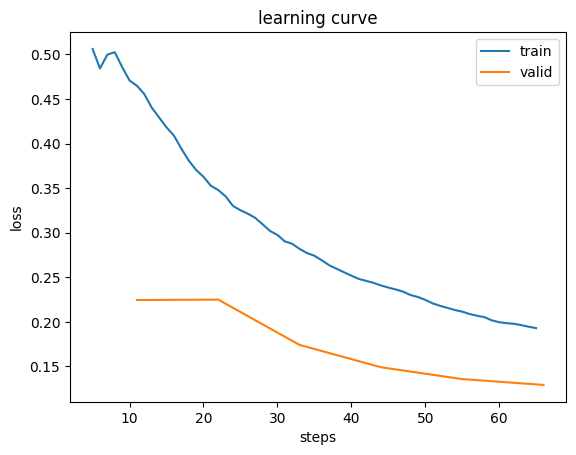

In [2]:
learn.fit_one_cycle(6,slice(1e-4,1e-2))
learn.recorder.plot_loss()


Valid Loss (MSE):       0.1292
Valid RMSE:             0.3595
Valid MAE:              0.2553
Valid R² score:         0.4634


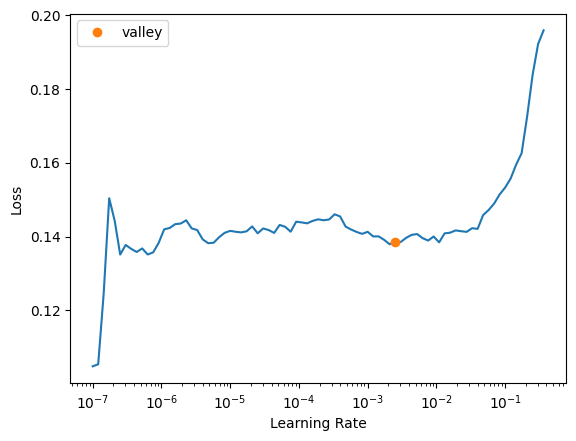

In [3]:
get_valid_data(learn,dls)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
import pandas as pd

# 1. Get model outputs & true targets on the valid set
probs_val, targs_val = learn.get_preds(dl=learn.dls.valid)
# ——> probs_val: (n_valid, n_classes) or (n_valid,1) if regressor
# ——> targs_val: (n_valid,)
surv_probs = probs_val[:,1]
plt.figure(figsize=(6,4))
plt.hist(surv_probs.numpy(), bins=20, edgecolor='k')
plt.xlabel('Predicted Survival Probability')
plt.ylabel('Count')
plt.title('Distribution of Survival Probabilities')
plt.show()
# 2. Turn those into hard labels
# If you have a 2‐class softmax head:
preds_class = (probs_val.argmax(dim=1))

# 3. Compute & plot the confusion matrix
cm = confusion_matrix(targs_val.cpu(), preds_class.cpu())

fig, ax = plt.subplots(figsize=(5,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(ax=ax)
plt.show()

# 4. Grab your original valid‐set DataFrame
valid_df = learn.dls.valid.dataset.items.copy()

# 5. Annotate with predictions and ground truth
valid_df['predicted'] = preds_class.numpy()
valid_df['actual']    = targs_val.numpy()

# 6. Filter to only the misclassified rows
misclassified = valid_df[valid_df['predicted'] != valid_df['actual']]

# 7. Inspect
print(f"Total misclassified: {len(misclassified)}")
misclassified.head()
age_na_count = misclassified[misclassified['Age_na'] == 2]
print(f"Number of rows with missing Age: {len(age_na_count)}")


In [ ]:
df = misclassified.copy()
not_dead = df[df['predicted'] == 1]
count_nd_female = (not_dead['Sex'] ==2).sum()
print(f"predict alive, false: {count_nd_female}")


dead = df[df['predicted'] == 0]
count_d_female = (dead['Sex'] ==2).sum()
print(f"predict dead, false: {count_d_female}")

In [ ]:
males_misclassified = (df['Sex'] == 1).sum()
print(f"count of misclassified males = {males_misclassified}")

In [4]:
learn.export('titanic_model_v7.pkl')